In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam
from tensorflow.keras import layers, models


In [2]:
# Directories for images and masks
image_dir = r"D:\pneumonia\Kaggle_Pneumonia1\image"
mask_dir = r"D:\pneumonia\Kaggle_Pneumonia1\mask"

# Image size and batch size
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 8

In [3]:
# Load image and mask paths
def load_image_mask_paths(base_image_dir, base_mask_dir):
    normal_image_dir = os.path.join(base_image_dir, 'normal')
    pneumonia_image_dir = os.path.join(base_image_dir, 'pneumonia')
    
    normal_mask_dir = os.path.join(base_mask_dir, 'normal')
    pneumonia_mask_dir = os.path.join(base_mask_dir, 'pneumonia')
    
    normal_image_paths = sorted([os.path.join(normal_image_dir, fname) for fname in os.listdir(normal_image_dir)])
    pneumonia_image_paths = sorted([os.path.join(pneumonia_image_dir, fname) for fname in os.listdir(pneumonia_image_dir)])
    
    normal_mask_paths = sorted([os.path.join(normal_mask_dir, fname) for fname in os.listdir(normal_mask_dir)])
    pneumonia_mask_paths = sorted([os.path.join(pneumonia_mask_dir, fname) for fname in os.listdir(pneumonia_mask_dir)])
    
    return normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths

# Load image and mask paths for normal and pneumonia
normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths = load_image_mask_paths(image_dir, mask_dir)


In [4]:
# Upsample normal images and masks
def upsample_images_and_masks(normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths):
    print(f"Before Upsampling - Normal: {len(normal_image_paths)}, Pneumonia: {len(pneumonia_image_paths)}")
    
    # Upsample normal images and masks
    normal_upsample_image = random.choices(normal_image_paths, k=len(pneumonia_image_paths))
    normal_upsample_mask = random.choices(normal_mask_paths, k=len(pneumonia_mask_paths))
    
    # Combine normal with pneumonia sets
    image_paths = normal_upsample_image + pneumonia_image_paths
    mask_paths = normal_upsample_mask + pneumonia_mask_paths
    labels = ['normal'] * len(normal_upsample_image) + ['pneumonia'] * len(pneumonia_image_paths)
    
    # Shuffle dataset
    combined = list(zip(image_paths, mask_paths, labels))
    random.shuffle(combined)
    
    image_paths, mask_paths, labels = zip(*combined)
    
    print(f"After Upsampling - Total images: {len(image_paths)}")
    
    return image_paths, mask_paths, labels

# Upsample normal images
image_paths, mask_paths, labels = upsample_images_and_masks(normal_image_paths, pneumonia_image_paths, normal_mask_paths, pneumonia_mask_paths)


Before Upsampling - Normal: 1341, Pneumonia: 3875
After Upsampling - Total images: 7750


In [5]:
# Data augmentation for images and masks
def image_mask_generator(image_paths, mask_paths, batch_size):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_mask_paths = mask_paths[i:i+batch_size]
            
            images = [tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE) for img_path in batch_image_paths]
            masks = [tf.keras.preprocessing.image.load_img(mask_path, target_size=IMAGE_SIZE, color_mode='grayscale') for mask_path in batch_mask_paths]
            
            images = np.array([np.array(img) for img in images])
            masks = np.array([np.array(mask) for mask in masks])
            
            # Binarize the masks
            masks = (masks > 128).astype(np.float32)
            yield images, masks

# Split dataset into training and validation
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)


In [6]:
# Create generators
train_gen = image_mask_generator(train_image_paths, train_mask_paths, BATCH_SIZE)
val_gen = image_mask_generator(val_image_paths, val_mask_paths, BATCH_SIZE)

# Early stopping during training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [7]:
# Define the U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoder
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    
    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
# Instantiate and compile the U-Net model
unet_model = unet_model(input_shape=(128, 128, 3))
unet_model.summary()

In [8]:
# Compile the model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(train_gen,
                    steps_per_epoch=len(train_image_paths) // BATCH_SIZE,
                    validation_data=val_gen,
                    validation_steps=len(val_image_paths) // BATCH_SIZE,
                    epochs=50,
                    callbacks=[early_stopping])

Epoch 1/50
775/775 [==============================] - 114s 142ms/step - loss: 0.2594 - accuracy: 0.8936 - val_loss: 0.2324 - val_accuracy: 0.9015
Epoch 2/50
775/775 [==============================] - 54s 70ms/step - loss: 0.2082 - accuracy: 0.9166 - val_loss: 0.1938 - val_accuracy: 0.9215
Epoch 3/50
775/775 [==============================] - 53s 68ms/step - loss: 0.1963 - accuracy: 0.9206 - val_loss: 0.1861 - val_accuracy: 0.9239
Epoch 4/50
775/775 [==============================] - 53s 68ms/step - loss: 0.1919 - accuracy: 0.9221 - val_loss: 0.1841 - val_accuracy: 0.9249
Epoch 5/50
775/775 [==============================] - 53s 68ms/step - loss: 0.1884 - accuracy: 0.9232 - val_loss: 0.1825 - val_accuracy: 0.9253
Epoch 6/50
775/775 [==============================] - 51s 66ms/step - loss: 0.1862 - accuracy: 0.9239 - val_loss: 0.1822 - val_accuracy: 0.9253
Epoch 7/50
775/775 [==============================] - 54s 69ms/step - loss: 0.1842 - accuracy: 0.9245 - val_loss: 0.1819 - val_accurac

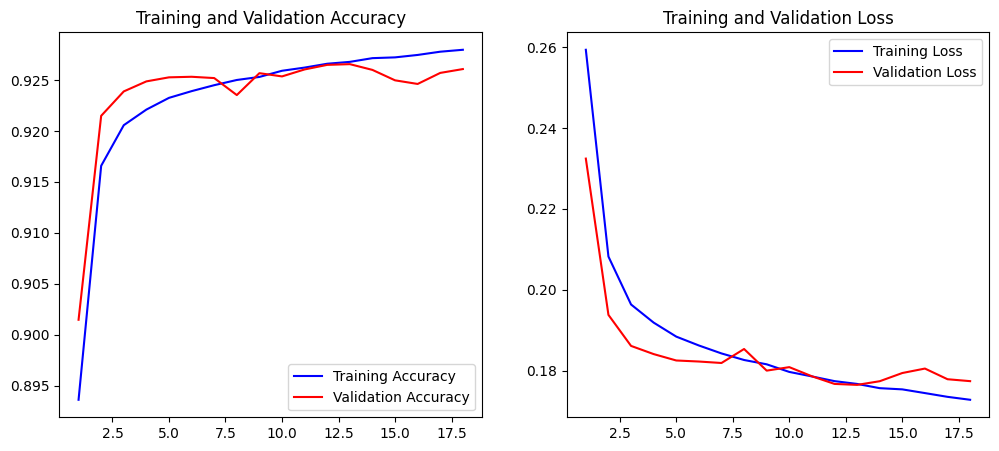

In [9]:
# Plot training and validation accuracy/loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

# Plot the training history
plot_training_history(history)

In [10]:
# Save the trained model
model.save('D:/pneumonia/Kaggle_Pneumonia1/saved_models/unet_model.h5')


In [12]:
# Load test image and mask paths
test_image_dir = r"D:\pneumonia\Kaggle_Pneumonia1\test_image"
test_mask_dir = r"D:\pneumonia\Kaggle_Pneumonia1\test_mask"

test_normal_image_paths, test_pneumonia_image_paths, test_normal_mask_paths, test_pneumonia_mask_paths = load_image_mask_paths(test_image_dir, test_mask_dir)

# Combine test image and mask paths
test_image_paths = test_normal_image_paths + test_pneumonia_image_paths
test_mask_paths = test_normal_mask_paths + test_pneumonia_mask_paths

# Create test generator
test_gen = image_mask_generator(test_image_paths, test_mask_paths, BATCH_SIZE)

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen, steps=len(test_image_paths) // BATCH_SIZE)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


80/80 [==============================] - 11s 130ms/step - loss: 0.1235 - accuracy: 0.9583
Test Loss: 0.12351463735103607, Test Accuracy: 0.958324134349823


In [13]:
# Recompile the model before evaluation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen, steps=len(test_image_paths) // BATCH_SIZE)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


80/80 [==============================] - 5s 55ms/step - loss: 0.1235 - accuracy: 0.9583
Test Loss: 0.12351462990045547, Test Accuracy: 0.958324134349823


1/1 [==============================] - 0s 123ms/step


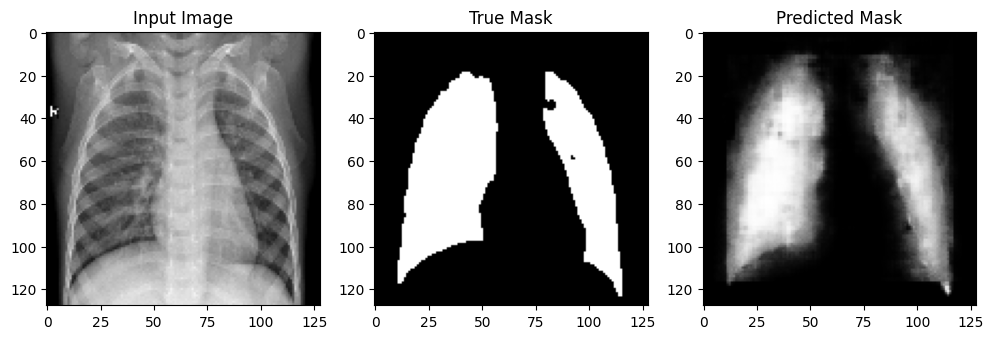

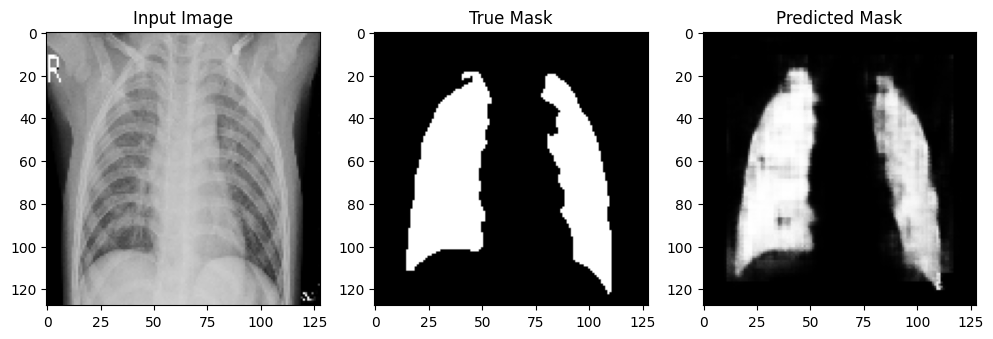

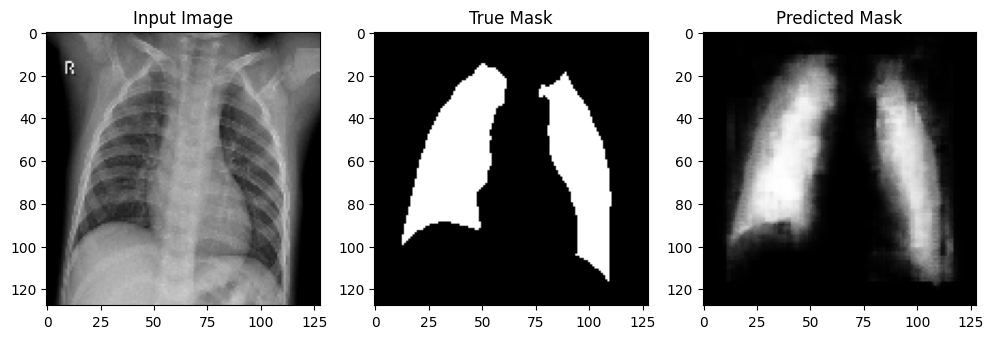

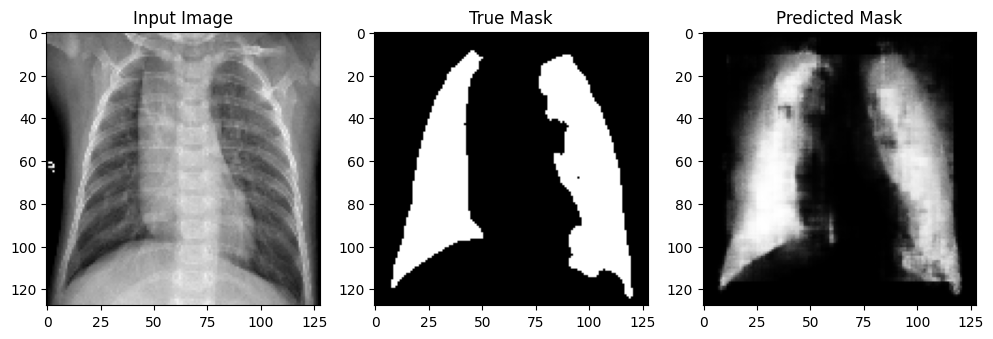

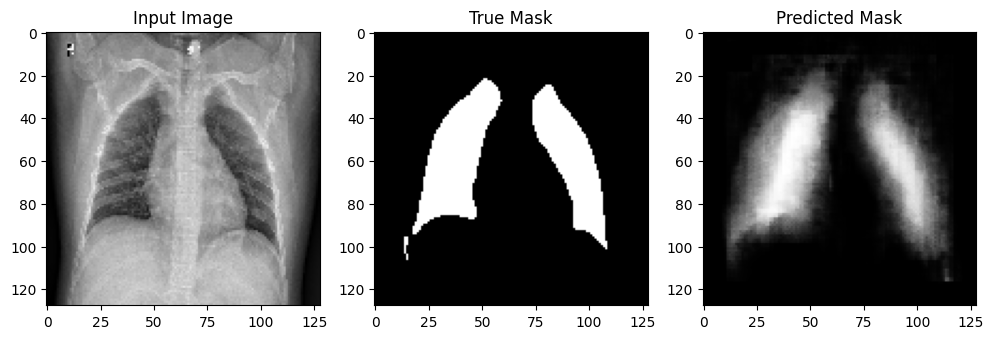

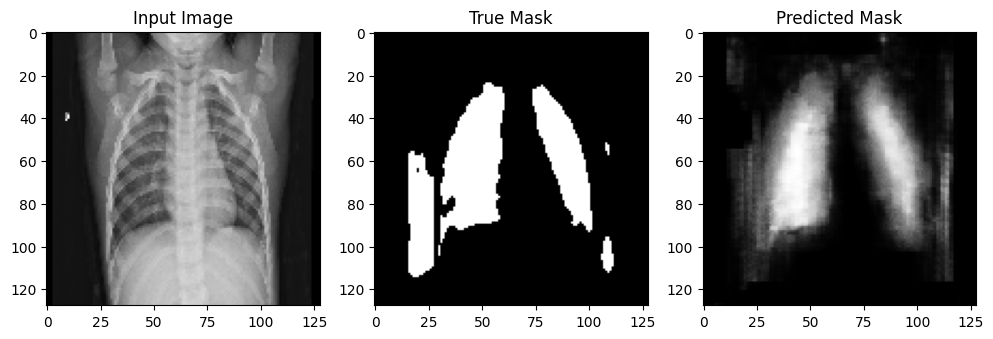

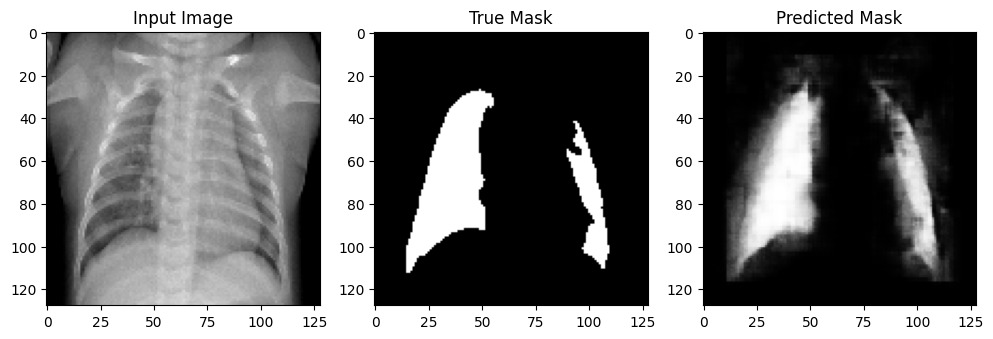

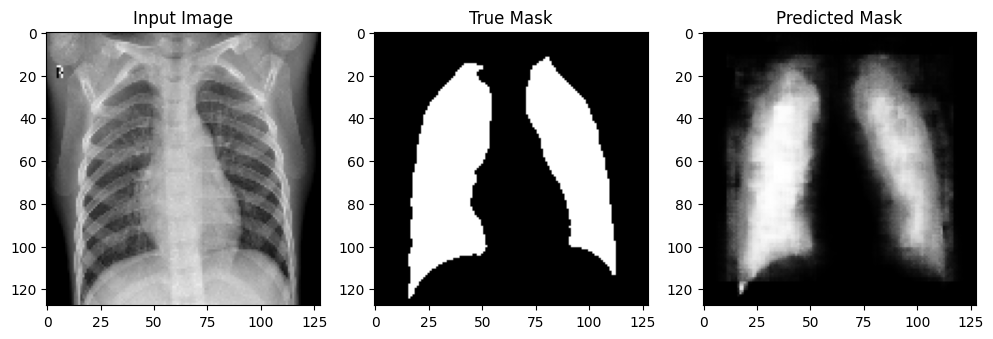

1/1 [==============================] - 0s 20ms/step


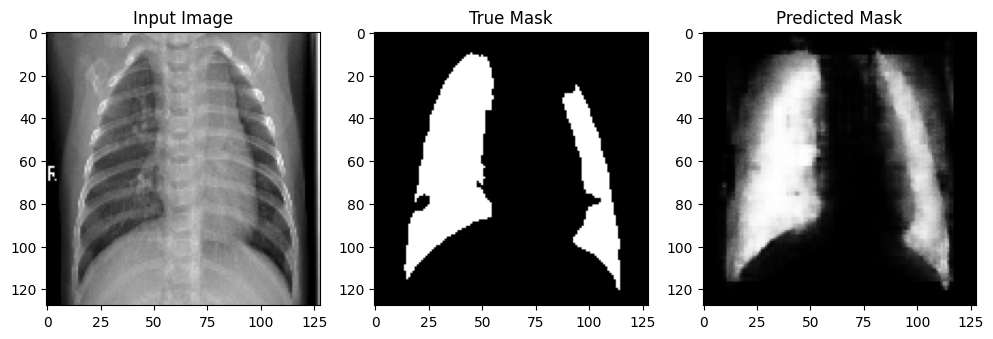

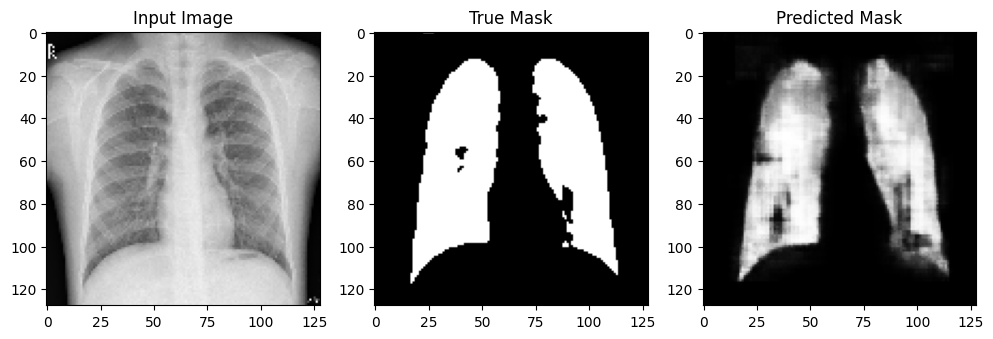

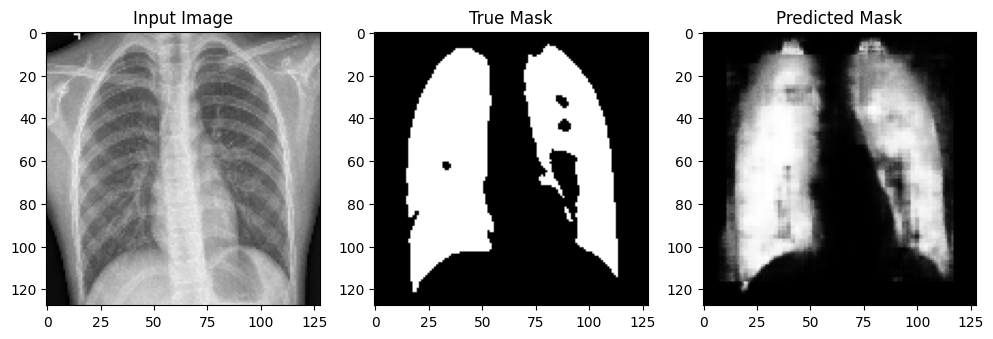

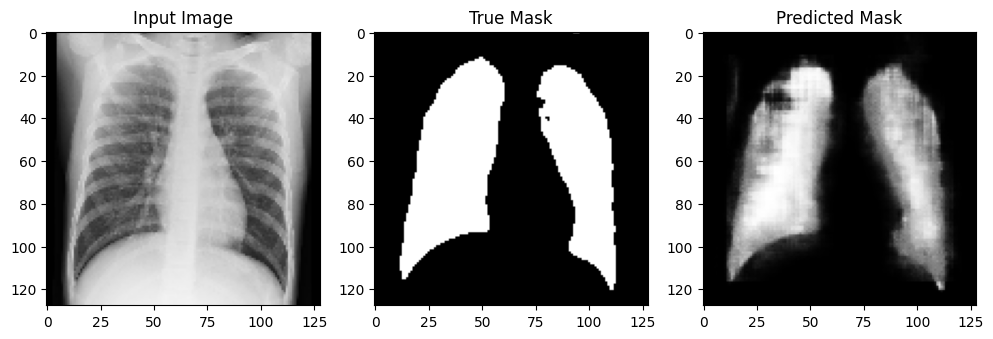

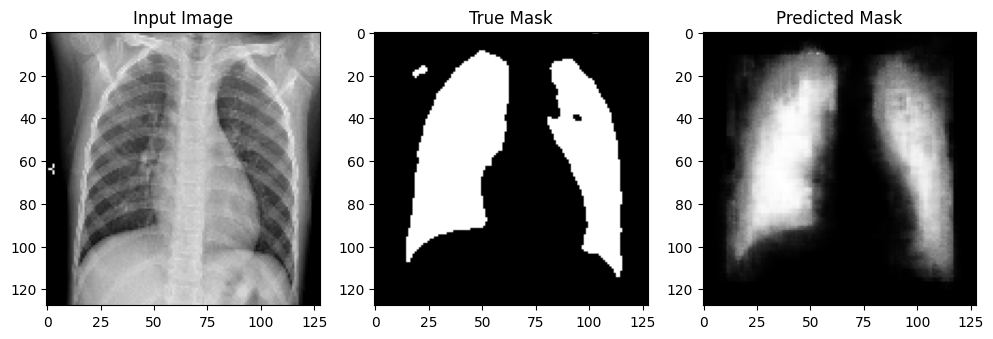

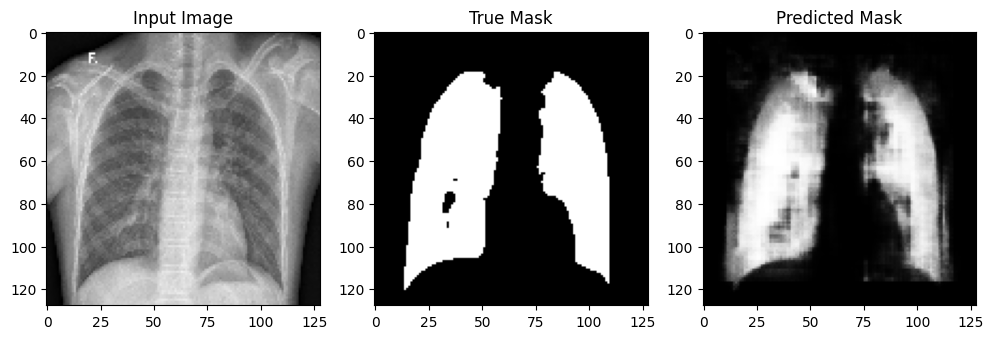

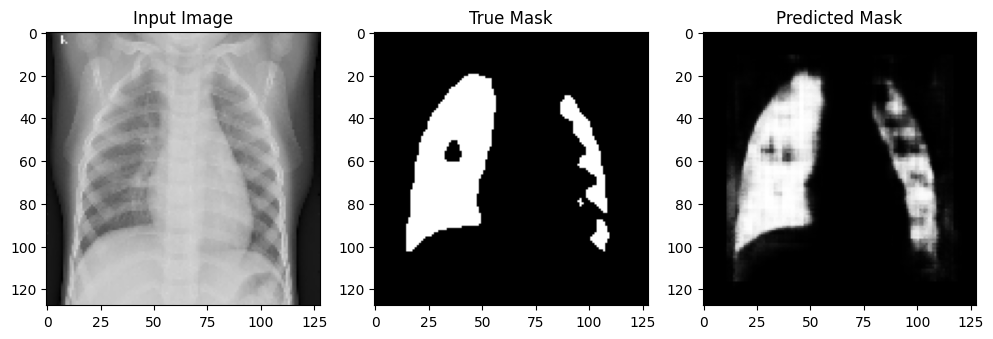

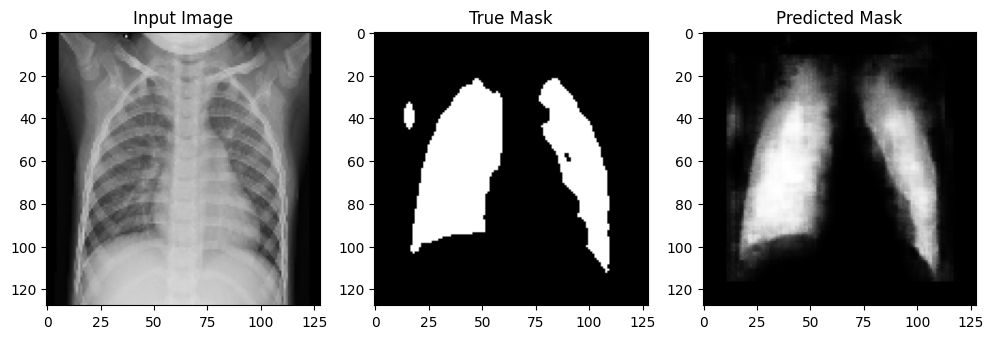

1/1 [==============================] - 0s 28ms/step


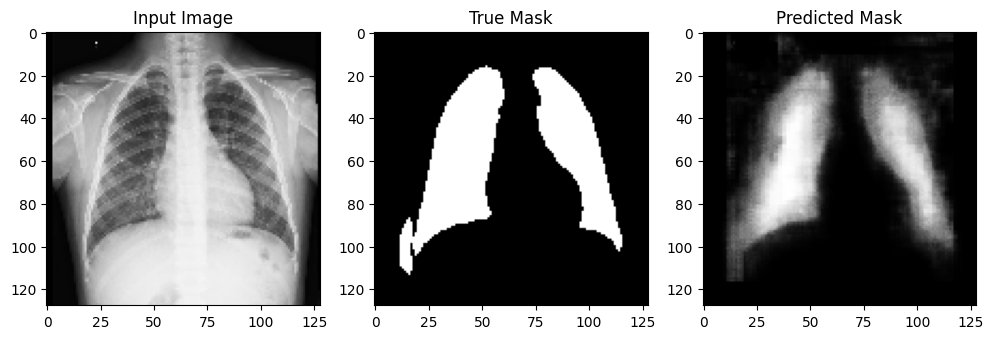

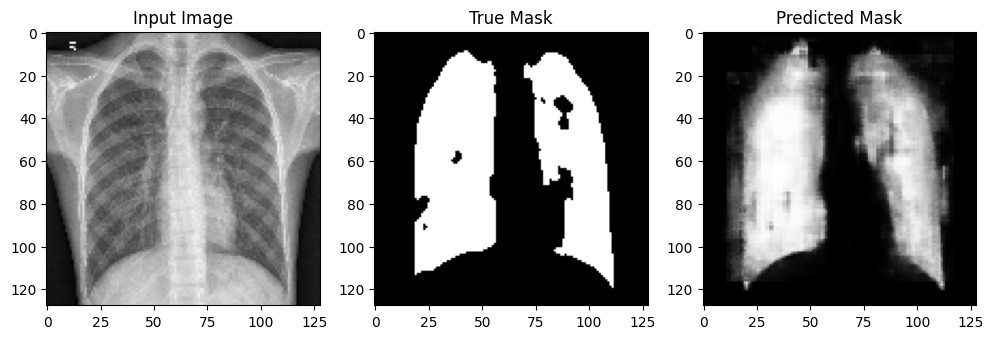

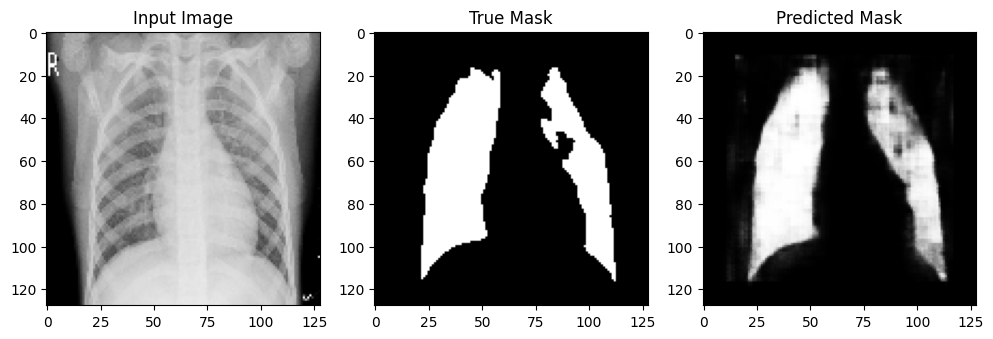

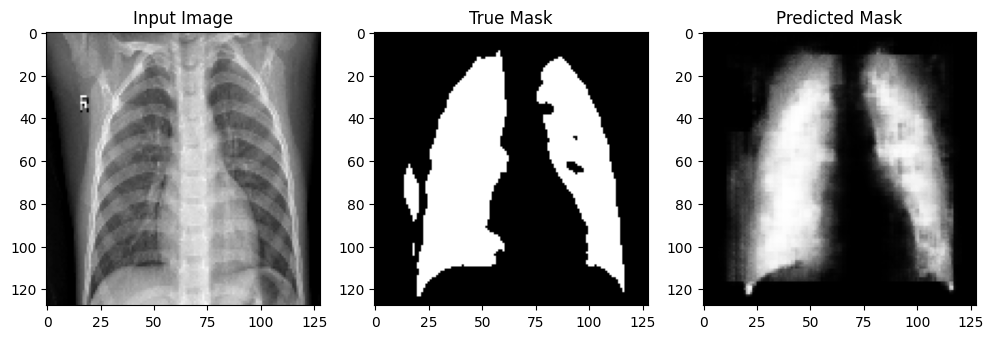

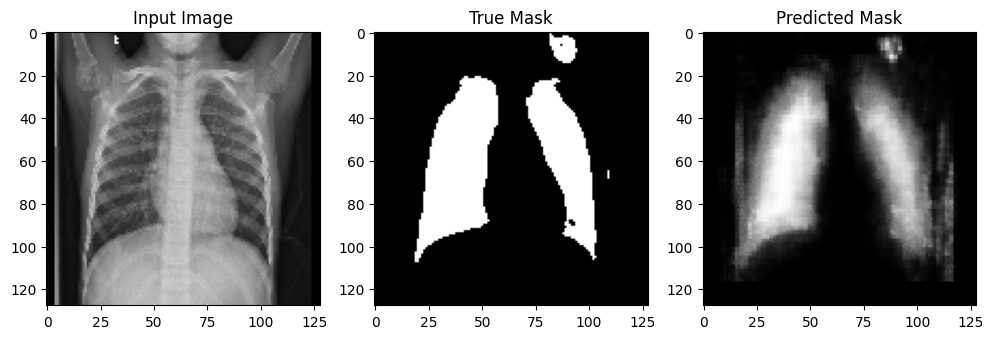

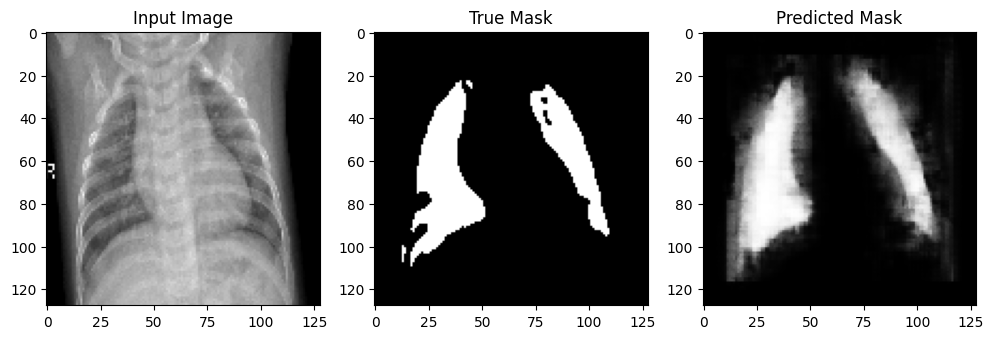

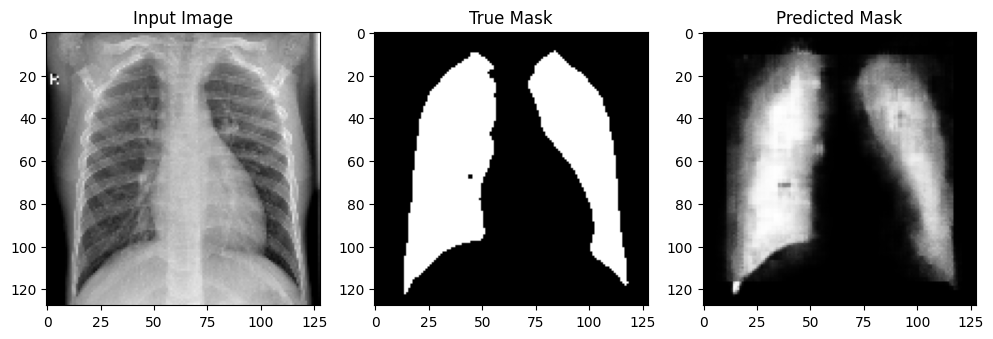

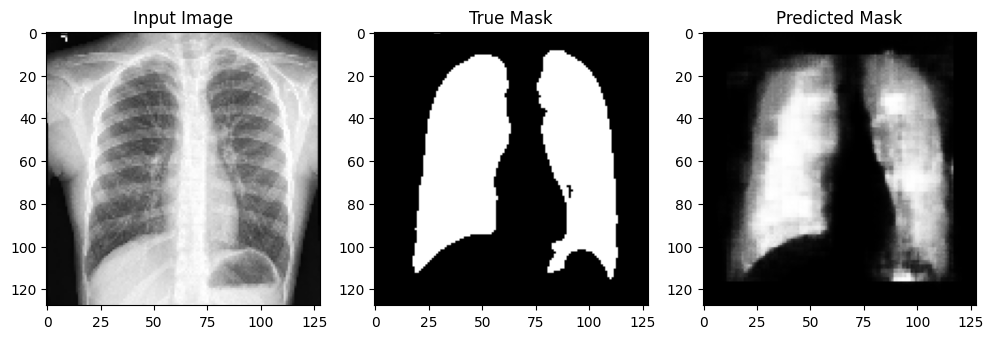

1/1 [==============================] - 0s 20ms/step


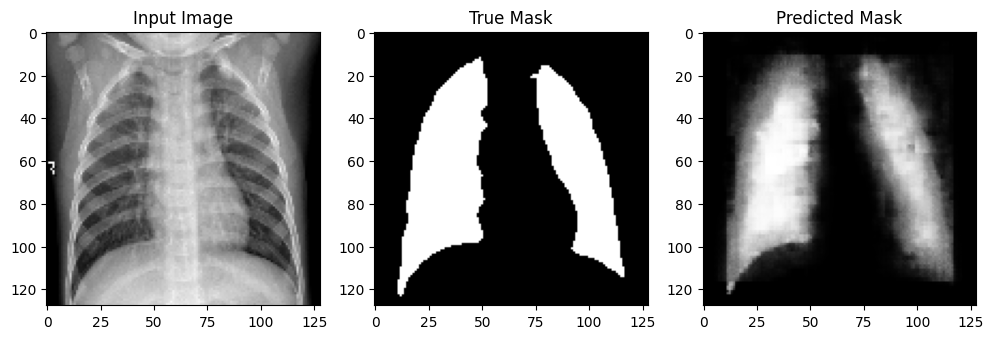

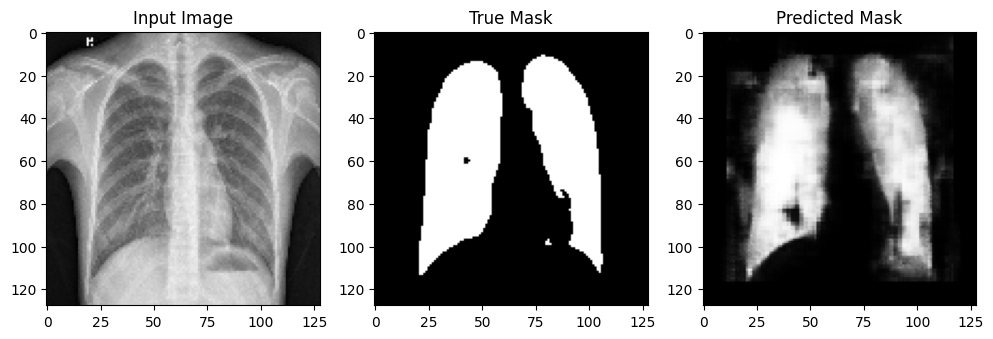

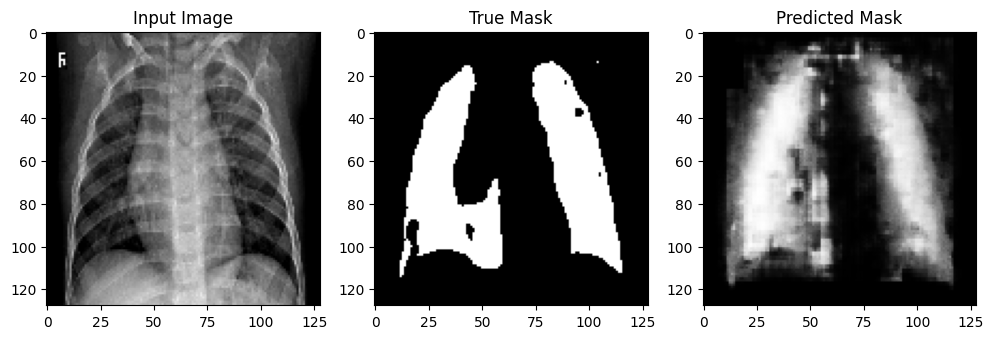

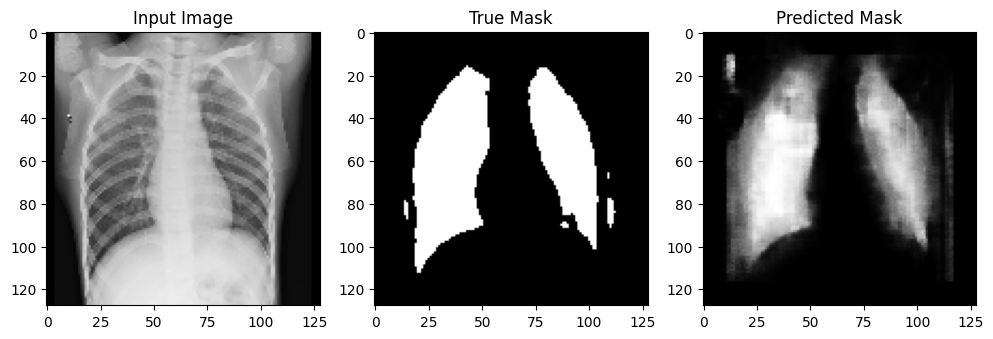

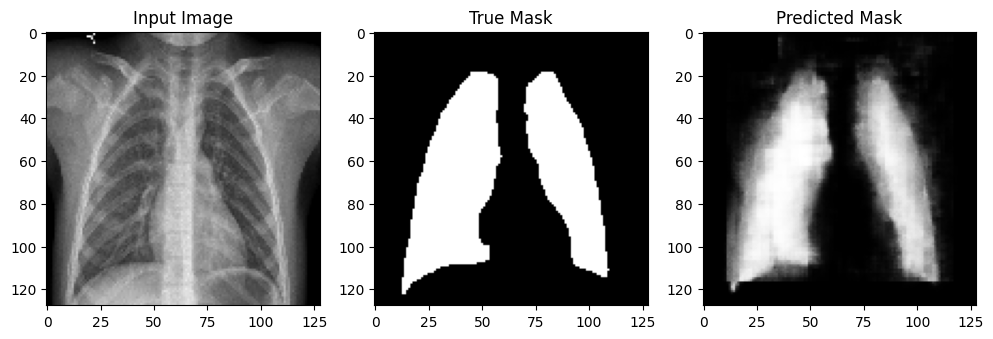

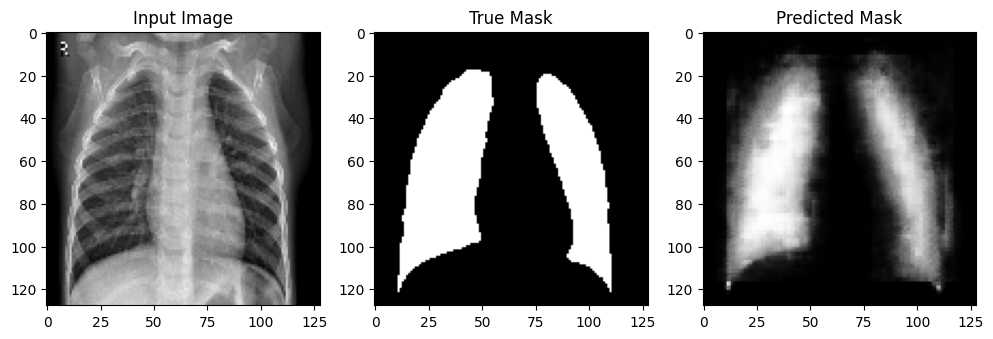

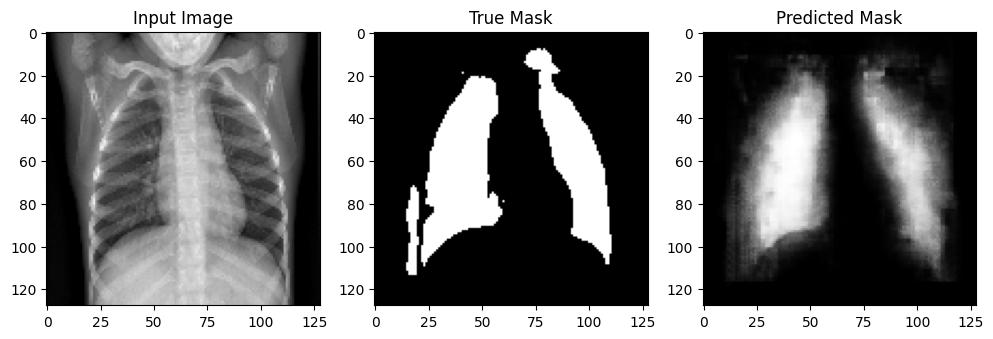

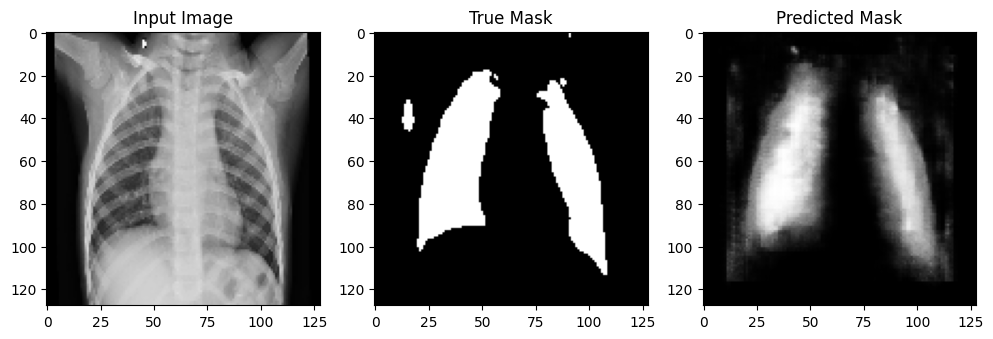

1/1 [==============================] - 0s 19ms/step


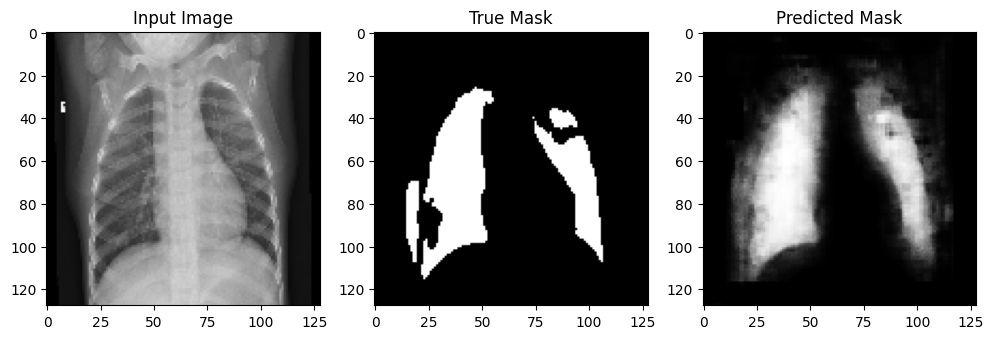

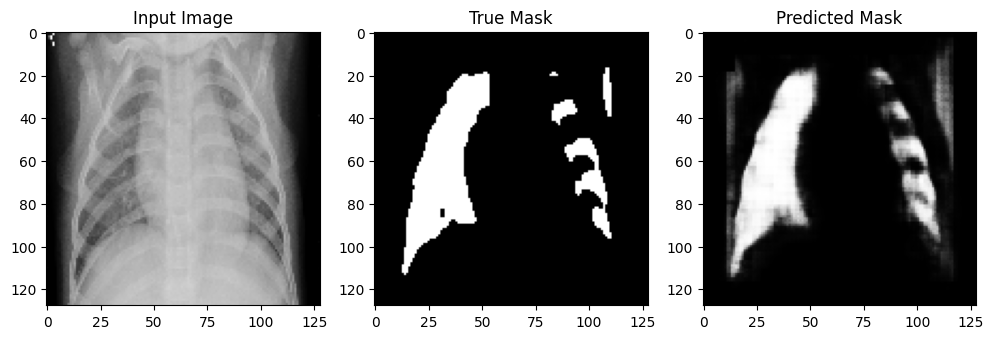

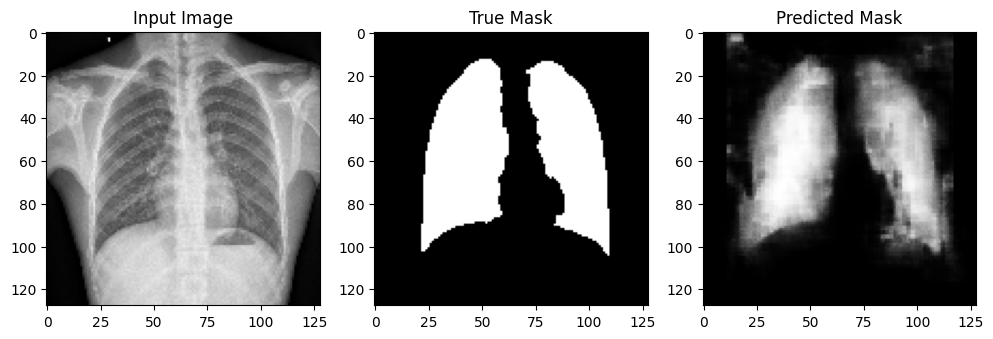

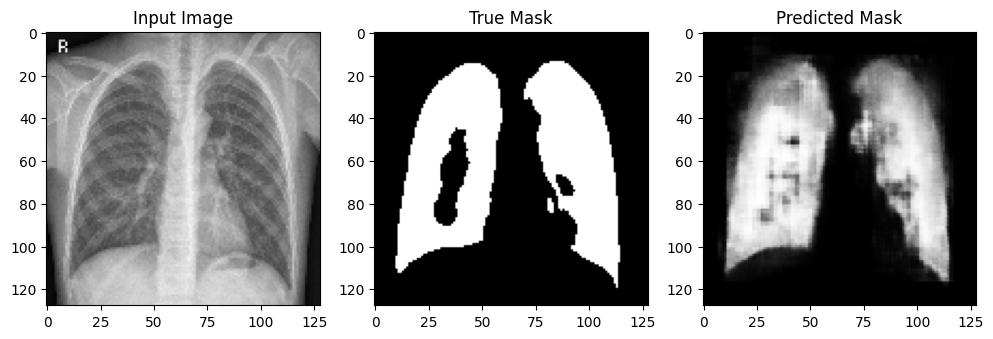

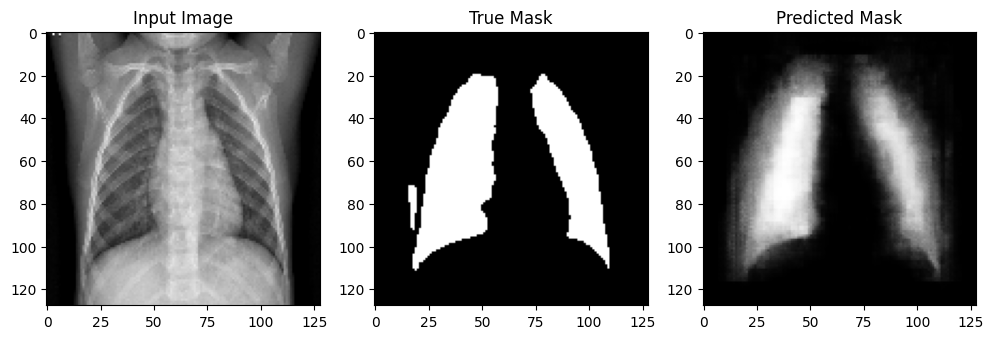

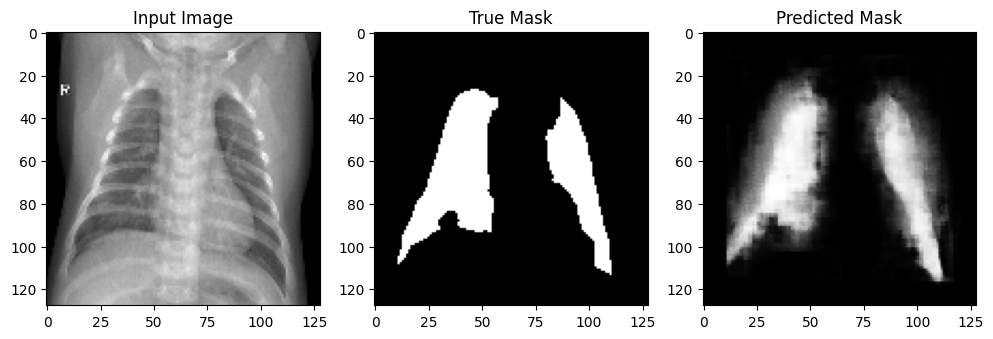

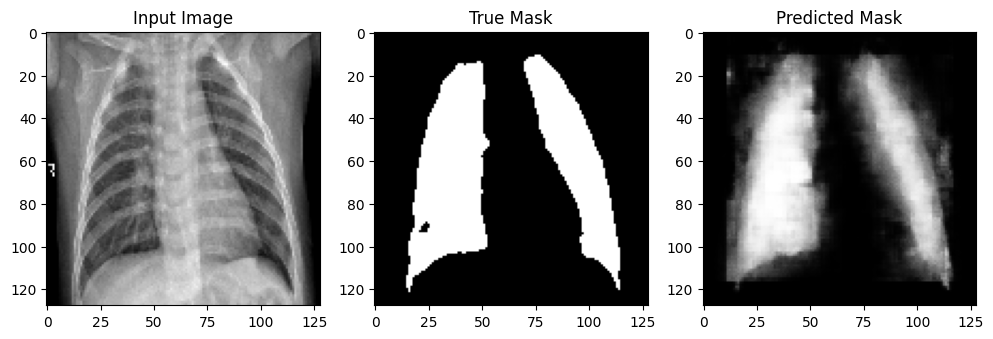

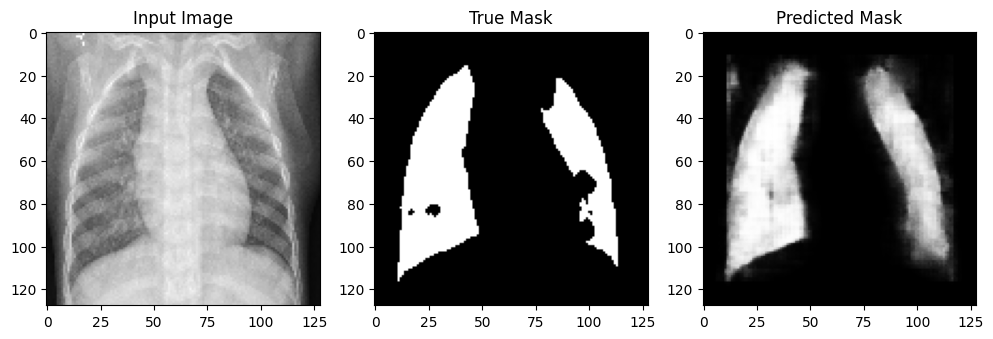

In [14]:
def visualize_predictions(test_gen, model, num_samples=5):
    for i in range(num_samples):
        images, true_masks = next(test_gen)
        predicted_masks = model.predict(images)
        
        for j in range(len(images)):
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 3, 1)
            plt.imshow(images[j].astype('uint8'))
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(true_masks[j].squeeze(), cmap='gray')
            plt.title('True Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks[j].squeeze(), cmap='gray')
            plt.title('Predicted Mask')

            plt.show()

# Visualize 5 samples from test set
visualize_predictions(test_gen, model)


In [15]:
# Save the trained U-Net model
model.save('pneumonia_segmentation_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [16]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    # Squeeze the last dimension of y_pred
    y_pred = np.squeeze(y_pred, axis=-1)
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    # Squeeze the last dimension of y_pred
    y_pred = np.squeeze(y_pred, axis=-1)
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Evaluate Dice Coefficient and IoU on test data
for i in range(len(test_image_paths)):
    img, true_mask = next(test_gen)
    pred_mask = model.predict(img)
    
    dice = dice_coefficient(true_mask, pred_mask)
    iou_value = iou(true_mask, pred_mask)
    
    print(f"Sample {i+1}: Dice Coefficient = {dice}, IoU = {iou_value}")


1/1 [==============================] - 0s 14ms/step
Sample 1: Dice Coefficient = 0.7829723158502226, IoU = 0.6433479912189377
1/1 [==============================] - 0s 37ms/step
Sample 2: Dice Coefficient = 0.7762687043562976, IoU = 0.6343457155382732
1/1 [==============================] - 0s 36ms/step
Sample 3: Dice Coefficient = 0.7310715687300895, IoU = 0.5761330195793267
1/1 [==============================] - 0s 33ms/step
Sample 4: Dice Coefficient = 0.7720473699315777, IoU = 0.6287273230518478
1/1 [==============================] - 0s 20ms/step
Sample 5: Dice Coefficient = 0.8059560452401541, IoU = 0.6749802149515762
1/1 [==============================] - 0s 24ms/step
Sample 6: Dice Coefficient = 0.7581259106215013, IoU = 0.6104692231778406
1/1 [==============================] - 0s 23ms/step
Sample 7: Dice Coefficient = 0.7482433443785449, IoU = 0.5977546362743621
1/1 [==============================] - 0s 22ms/step
Sample 8: Dice Coefficient = 0.7397978866256703, IoU = 0.587047043

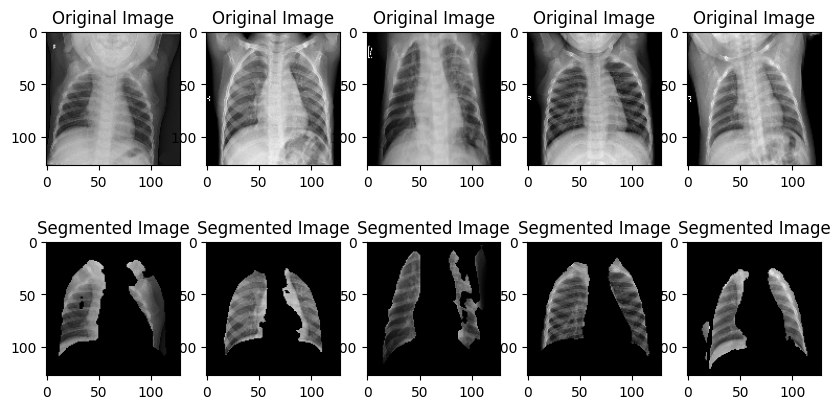

In [17]:
def apply_mask(image, mask):
    """ Apply the binary mask to the image. """
    return image * np.expand_dims(mask, axis=-1)

# Example usage on some sample images and masks
sample_images, sample_masks = next(train_gen)
segmented_images = [apply_mask(image, mask) for image, mask in zip(sample_images, sample_masks)]

# Visualize the result
plt.figure(figsize=(10, 5))
for i in range(5):  # Show 5 examples
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].astype('uint8'))
    plt.title('Original Image')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(segmented_images[i].astype('uint8'))
    plt.title('Segmented Image')
plt.show()


In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def build_feature_extractor(input_shape=(128, 128, 3)):
    # Load pre-trained VGG16 without the top classification layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Extract features from the last convolutional layer
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
    
    return feature_extractor

# Build the feature extractor model
feature_extractor = build_feature_extractor()

# Extract features from the segmented images
segmented_images_np = np.array(segmented_images)
features = feature_extractor.predict(segmented_images_np)

features_flattened = features.reshape(features.shape[0], -1)  # Flatten to shape (num_images, feature_size)


print(f"Extracted feature shape: {features.shape}")




1/1 [==============================] - 1s 1s/step
Extracted feature shape: (8, 8, 8, 512)


In [19]:
# Flatten the features for classification
features_flattened = features.reshape(features.shape[0], -1)  # Shape: (num_images, 8*8*512)
print(f"Flattened feature shape: {features_flattened.shape}")


Flattened feature shape: (8, 32768)


In [20]:
labels = ['normal', 'pneumonia', 'normal', 'pneumonia', 'normal', 'pneumonia', 'normal', 'pneumonia']


In [21]:
from sklearn.preprocessing import LabelEncoder

# Create the label encoder and fit it on the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)  # This will convert 'normal' and 'pneumonia' to numeric values (0 or 1)


In [22]:
from sklearn.linear_model import LogisticRegression

# Create and fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(features_flattened, encoded_labels)


LogisticRegression()

In [23]:
# Predict on the same dataset
predictions = log_reg.predict(features_flattened)

# Check the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(encoded_labels, predictions)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 100.00%


In [24]:
# Preprocess test images
test_images, test_masks = next(test_gen)  # Get test images and masks from the generator

# Segment the test images using U-Net
segmented_test_images = [apply_mask(image, mask) for image, mask in zip(test_images, test_masks)]
segmented_test_images_np = np.array(segmented_test_images)

# Extract features from test images
test_features = feature_extractor.predict(segmented_test_images_np)
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Prepare test labels and encode
test_labels = ['normal', 'pneumonia']  # Add corresponding test labels here
test_encoded_labels = label_encoder.transform(test_labels)

# Make predictions on test data
test_predictions = log_reg.predict(test_features_flattened)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(encoded_labels, test_predictions)  # test_labels should match test data
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


1/1 [==============================] - 0s 18ms/step
Test accuracy: 62.50%


              precision    recall  f1-score   support

      normal       0.67      0.50      0.57         4
   pneumonia       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8



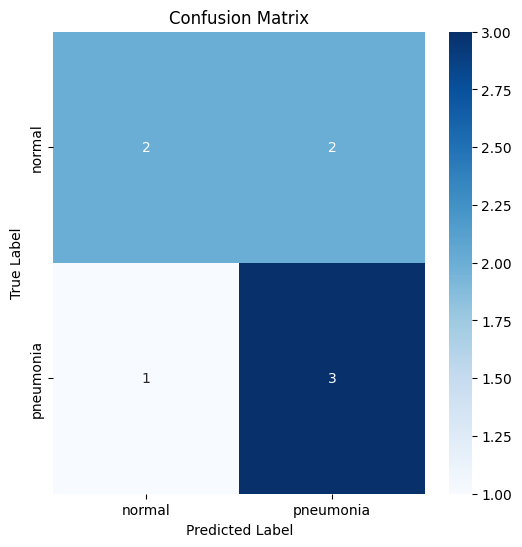

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate a classification report
print(classification_report(encoded_labels, test_predictions, target_names=label_encoder.classes_))

# Create a confusion matrix
cm = confusion_matrix(encoded_labels, test_predictions)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [26]:
import joblib

# Save logistic regression model
joblib.dump(log_reg, 'pneumonia_logistic_model.pkl')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# U-Net model is already saved, as done previously
# Save the trained U-Net model
model.save('pneumonia_segmentation_model.h5')
print("Model saved successfully.")

Model saved successfully.
